In [22]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch
import pandas as pd
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns


## Extraccion de carcteristicas

In [5]:
import os
import numpy as np
import pandas as pd

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=2000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    return mfccs_mean

def encode(data_dir, csv_file):
    df = pd.read_csv(os.path.join(data_dir, csv_file))
    data = []
    labels = []
    
    for index, row in df.iterrows():
        file_name = f"train/train/{row['idx']}.wav"
        file_path = os.path.join(data_dir, file_name)
        if os.path.exists(file_path):
            features = extract_features(file_path)
            data.append(features)
            labels.append(1 if row['class'] == 'RightWhale' else 0)
    
    data = np.array(data)
    labels = np.array(labels)
    return data, labels


## Extraemos MFCCs

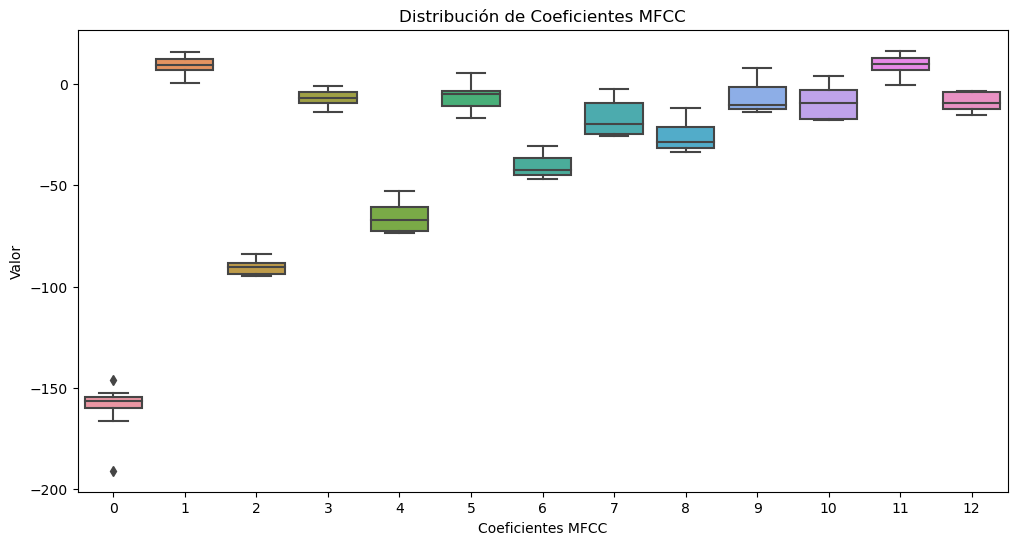

In [7]:

file_path = './data/train/train/1.wav'
y, sr = librosa.load(file_path, sr=2000)


Audio(data=y, rate=sr)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13) 
mfcc_df = pd.DataFrame(mfccs.T) 
plt.figure(figsize=(12, 6)) 
sns.boxplot(data=mfcc_df) 
plt.title('Distribución de Coeficientes MFCC') 
plt.xlabel('Coeficientes MFCC') 
plt.ylabel('Valor') 
plt.show()

In [8]:
data_dir = './data'
train_csv = 'train.csv'

x, y = encode(data_dir, train_csv)



### Aplicamos normalizacion

In [9]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

### Aplicamos PCA como reduccion de dimensioalidad

In [10]:
pca = PCA()
pca.fit(x_scaled)

PCA()

Número óptimo de componentes principales: 11


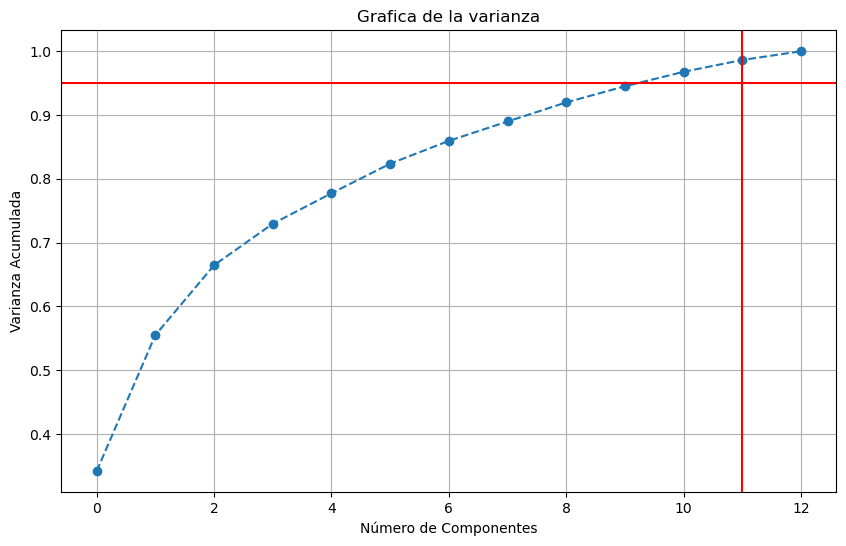

In [11]:

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)


n_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f'Número óptimo de componentes principales: {n_components}')

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x=n_components, color='r', linestyle='-')
plt.title('Grafica de la varianza')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.grid(True)
plt.show()

In [12]:
pca = PCA(n_components=n_components)
x_pca = pca.fit_transform(x_scaled)

### Realizamos split para tener train y test

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)


In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
x = torch.tensor(x_train, dtype=torch.float32)
y = torch.tensor(y_train, dtype=torch.float32)

x_t = torch.tensor(x_test, dtype=torch.float32)
y_t = torch.tensor(y_test, dtype=torch.float32)


x = x.to(device)
y = y.to(device)
x_t = x_t.to(device)
y_t = y_t.to(device)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cpu
cpu


In [15]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out


In [16]:
loss_fn = nn.BCEWithLogitsLoss()
input_size = 11  
hidden_size = 30
model1 = MLP(input_size, hidden_size).to(device)

example_input = torch.randn(1, 11).to(device)
output = model1(example_input)

optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=1000, gamma=0.5)

In [17]:
def train(model, loss_f, optimizer, scheduler, epochs, x_train, y_train, device):
    loss_lista = []
    for epoch in range(epochs):
        x_train = x_train.to(device)
        y_train = y_train.to(device).view(-1, 1)

        y_pred = model(x_train)
        loss = loss_f(y_pred, y_train)
        loss_lista.append(loss.cpu().item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if epoch % 500 == 0:
            print('Epoch {}: train loss: {}'.format(epoch, loss.item()))

    return loss_lista

In [18]:
loss_list1 = train(model1, loss_fn, optimizer1, scheduler, epochs=4000, x_train=x, y_train=y, device=device)

Epoch 0: train loss: 0.6998205184936523
Epoch 500: train loss: 0.41880106925964355
Epoch 1000: train loss: 0.41340044140815735
Epoch 1500: train loss: 0.41320282220840454
Epoch 2000: train loss: 0.406928151845932
Epoch 2500: train loss: 0.4094489812850952
Epoch 3000: train loss: 0.4051806926727295
Epoch 3500: train loss: 0.4084746539592743


In [19]:

def matriz_confusion(y_test, y_pred, Tipo):
    # Calcular la matriz de confusión
    matrix = confusion_matrix(y_test, y_pred)
    
    f2 = pd.DataFrame(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], index=["NoWhale", "RightWhale"], columns=["NoWhale", "RightWhale"])
    
    # Graficar la matriz de confusión
    sns.heatmap(f2, annot=True, cbar=None, cmap="Greens")
    plt.title("Confusion Matrix " + Tipo), plt.tight_layout()
    plt.xlabel("Predicted")
    plt.ylabel("Real")
    plt.show()

F1 Score: 0.7980727113447219
Precision: 0.7887445887445887
Recall: 0.8076241134751773


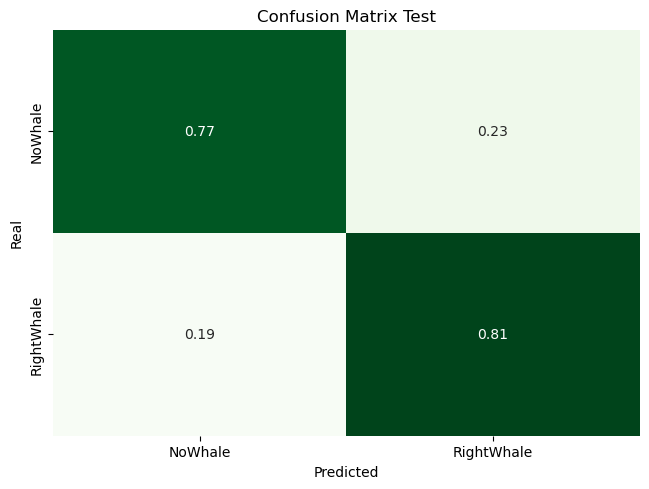

In [23]:

def test(model, x_test, y_test):
    model.eval()
    x_test = x_test.to(device).float()
    y_test = y_test.to(device).float().unsqueeze(1)
    with torch.no_grad():
        y_pred = model(x_test)
        y_pred_labels = torch.sigmoid(y_pred) >= 0.5

    y_test_labels = y_test.squeeze().cpu().numpy()
    y_pred_labels = y_pred_labels.squeeze().cpu().numpy()

    f1 = f1_score(y_test_labels, y_pred_labels)
    precision = precision_score(y_test_labels, y_pred_labels)
    recall = recall_score(y_test_labels, y_pred_labels)

    print(f'F1 Score: {f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    matriz_confusion(y_test_labels, y_pred_labels, "Test")

test(model1, x_t, y_t)

## Generamos imagen que representa la red neuronal

In [28]:

from torchviz import make_dot

dot = make_dot(output, params=dict(model1.named_parameters()))
dot.format = 'png'
dot.render('mlp_graph')

'mlp_graph.png'